In [35]:
## imports
#%matplotlib qt


import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os, fnmatch
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path
from scipy import integrate
import itertools

## Import our methods 
from ProcessGeodesics import GetGeodesicTrajectory, GetGeodesicIndices, \
    GetGeodesicsXTurnsIndices, GetGeodesicsXTurnsIndicesGreater, \
    GetTime, GetCameraPosition, GetCameraData, GrabSurfaceIndices

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Helper functions

In [2]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][0]
    TUpIndex = np.where(time >= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def CutTimesArray(time, Arr, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0] 
    if(len(TLowIndex) > 0):
        TLowIndex = TLowIndex[-1]
    else:
        TLowIndex = 0
    TUpIndex = np.where(time >= TUp)[0]
    if(len(TUpIndex) > 0):
        TUpIndex = TUpIndex[0]
    else:
        TUpIndex = -1
        
    time = time[TLowIndex:TUpIndex]
    Ans = []
    for data in Arr:
        Ans.append(data[TLowIndex:TUpIndex])
    return time, Ans 


def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)



## Read in horizon data 

In [3]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

def read_horizon_radii(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/JoinedLev" + Lev + "/ApparentHorizons/Ah" + Horizon + ".dat"
    t, min_r, max_r = np.loadtxt(f, comments="#",usecols=([0,5,6]),unpack=True)
    return t, min_r, max_r


## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
    return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
def distance_to_horizon(time, xx, yy, zz):
    """ time, x,x yy, zz are scalars for the position"""
    if time <= t_merger:
        min_dist = 1e10
        for horizon in ["A", "B"]:
            """ Have to minimize over AhA and AhB distances"""
            xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
        return sqrt(min_dist)
    elif time > t_merger:
        xx_h, yy_h, zz_h = horizon_at_time(time, "C")
        dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
        return sqrt(dist)
    else:
        print("somehow here")
        print(time, t_merger, t_ringdown)
                
def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        dist_horizon = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)

    return(sqrt(min_distance))
            

## Plot geodesic trajectories

In [107]:
## Plot geodesic trajectories
def PlotGetTrajectoriesFromH5(p):

    Indices = GetGeodesicsXTurnsIndicesGreater(p, 6) 
    #Indices = GetGeodesicsXTurnsIndices(p, 1) 
    #Indices = GetGeodesicIndices(p, infinity=False)
    print(len(Indices))
    
    Indices = Indices[-10:]
    #Indices = [64330]
    Indices = [20483]
    print(Indices)
    
    cs = sns.color_palette('Paired', n_colors=len(Indices))
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    for n, color in zip(Indices, cs):
        t, x, y, z = GetGeodesicTrajectory(p, n)
        ax.plot(x, y, z, '-', lw = 2.0, label = n, color = color)
        print(x[0], y[0], z[0])
                
    #Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, y_h, z_h, color='black', lw = 2.0, ls='-')
        

    ax.set_xlabel('x/M',labelpad=20)
    ax.set_ylabel('y/M', labelpad=20)
    ax.set_zlabel('z/M', labelpad=20)
    
    lim = 20.0
    #ax.set_xlim(-lim, lim)
    #ax.set_ylim(-lim, lim)
    #ax.set_zlim(-lim, lim)
    
    ax.set_title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo['tick']['inward_factor'] = 0
    ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.yaxis._axinfo['tick']['inward_factor'] = 0
    ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['inward_factor'] = 0
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
    #ax.set_axis_off()

    plt.legend()
    plt.tight_layout()
    plt.show()
    


8
[20483]
42.71699298339782 -50.50514517114641 -90.98994710623775


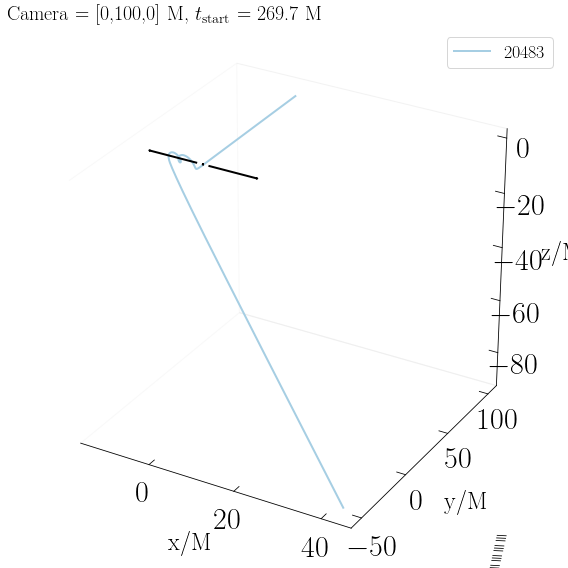

In [108]:
D = ['0_100_0_269.7'] #, '0_106_0_276.8', '0_116_0_287', '0_128_0_298.1']
for d in D:
    p = 'Data/TraceHeadOn_' + d + '/'
    PlotGetTrajectoriesFromH5(p)

## Plot time geodesics

In [98]:
## Plot geodesic trajectories in a time - x coordinate plot
def PlotTimeTrajectories(p):

    #Indices = GetGeodesicsXTurnsIndices(p, 1)
    #Indices = GetGeodesicIndices(p)
    #print(len(Indices))
    Indices = GetGeodesicsXTurnsIndicesGreater(p, 5) #, N_less = 1)
    #Indices = GetGeodesicIndices(p)
    print(len(Indices))
    #Indices = Indices[::100]
    Indices = [20483] #, 35912, 38188, 20749, 37710, 22160, 21336, 35519]
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    #cross_times = []
    
    for n in Indices:
        t, x, y, z = GetGeodesicTrajectory(p, n)
        
        ## Try to find the time where the first crossing happens based on x
        ## First set everything to 1 starting, and then grab the location 
        #sign = np.sign(x)/np.sign(x)[0]
        #sign_loc = np.where(sign == -1)[0]
        #if len(sign_loc) > 0:
        #    sign_loc = sign_loc[0]
        #    turn_time = t[sign_loc]
        #    cross_times.append(turn_time)
        plt.plot(x, t, '-', lw = 0.5, color = '#4391a8', alpha=0.5)
        
    #print(cross_times)
    #print(max(cross_times))
    #plt.axhline(max(cross_times), alpha=0.5, color='green')
    #Add in the horizons
    for horizon in ["A", "B", "C"]:
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, t_h, color='gray', lw = 3.0, ls='-', alpha=0.8, label = 'Horizon centers' if horizon == "C" else '')
        if horizon == "C":
            t_h, min_r, max_r = read_horizon_radii(horizon)
            plt.plot(x_h + max_r, t_h, color='black', label='AhC extents', lw = 1.0)
            plt.plot(x_h - max_r, t_h, color='black', lw = 1.0)
            plt.plot(x_h + min_r, t_h, color='black', lw = 1.0)
            plt.plot(x_h - min_r, t_h, color='black', lw = 1.0)

    plt.ylabel('t/M')
    plt.xlabel('x/M')
    plt.xlim(-30, 30)
    plt.ylim(50, t[-1] + 2)
    plt.axvline(0.0, color='black', lw = 1.0)

    ax.set_title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')
    plt.axhline(153.81, color='red', ls = '--', lw = 1.0, label = 'Ringdown grid switch')
    plt.axhline(float(GetTime(p)) - 100, color='pink', lw = 1.0, label = r'$t_\mathrm{start} - R_\mathrm{camera}$')
    #plt.legend()
    plt.tight_layout()
    plt.show()
    


148


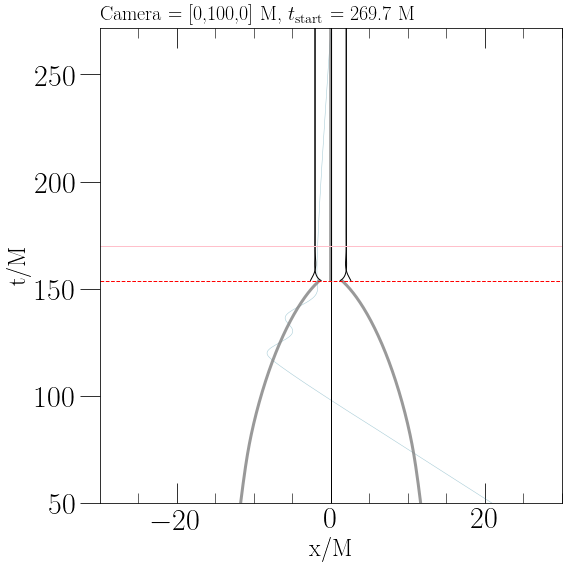

In [99]:
D = ['0_100_0_269.7'] #, '0_100_0_281.1', '0_106_0_276.8', '0_116_0_287', '0_128_0_298.1']
for d in D:
    p = 'Data/TraceHeadOn_' + d + '/'
    PlotTimeTrajectories(p)

## Histogram the crossing times

In [21]:
def CrossingHistograms(p):

    Indices = GetGeodesicsXTurnsIndicesGreater(p, 4) 
    #print(len(Indices))
    Indices = Indices[::100]

    fig, ax = plt.subplots(figsize=(8,8))
    
    cross_times = []
    
    for n in Indices:
        t, x, y, z = GetGeodesicTrajectory(p, n)

        sign = np.sign(x)/np.sign(x)[0]
        sign_loc = np.where(sign == -1)[0]
        if len(sign_loc) > 0:
            sign_loc = sign_loc[0]
            turn_time = t[sign_loc]
            cross_times.append(turn_time)
        
    #print(cross_times)
    print(max(cross_times))
    plt.xlabel('Crossing times')
    
    plt.hist(cross_times, facecolor='green', alpha=0.2)
    plt.axvline(max(cross_times), color='black')
    plt.tight_layout()
    plt.show()

In [ ]:
for t_start in [260, 265, 270, 275]: #, 260, 265, 268.6, 269.7, 272, 275]:
    p = 'Data/TraceHeadOn_0_0_100_' + str(t_start) + '/'
    CrossingHistograms(p)

## Plot lensing refinement method results + final positions

In [89]:
## Plot X, Y camera data and kappas on top of it

def PlotRefinementMethodResult(p, shadow=False, xturns=False):
    
    tags, x_pos, y_pos, surface = GetCameraData(p)

    fig = plt.figure(figsize=(10,8))
    
    if shadow:
        
        s = 5.0
    
        inf = GrabSurfaceIndices(surface, 1)
        aha = GrabSurfaceIndices(surface, 2)
        ahb = GrabSurfaceIndices(surface, 3)
        ahc = GrabSurfaceIndices(surface, 4)
        infty = GrabSurfaceIndices(surface, 7)
        
        plt.scatter(x_pos[infty], y_pos[infty], s=s, c='#aeebd8', label=r'Out to $\infty$')
        plt.scatter(x_pos[inf], y_pos[inf], s=s, c='lightblue', label=r'Out to $\infty$')
        plt.scatter(x_pos[aha], y_pos[aha], s=s, c='#00abd1', label=r'Close to AH A')
        plt.scatter(x_pos[ahb], y_pos[ahb], s=s, c='#d10084', label=r'Close to AH B', picker = 1)
        plt.scatter(x_pos[ahc], y_pos[ahc], s=s, c='black', label=r'Close to Final AH')
        
        #tolerance = 1 # points
        #ax.plot(range(10), 'o', picker=tolerance)
        
        def on_pick(event):
            ind = event.ind
            print(ind, x_pos[ahb][ind], y_pos[ahb][ind], tags[ahb][ind])
            print()

        fig.canvas.callbacks.connect('pick_event', on_pick)
    
    elif xturns:
        
        s = 1.0
        nums = [1, 2, 3, 4, 5, 6, 7] 
        #nums = [5, 6, 7, 8]
        cs = ['green', 'orange', 'purple', '#00eeff', 'black', 'blue', 'red', 'yellow', 'black']
        
        for num, color in zip(nums, cs):
            
            ii = GetGeodesicsXTurnsIndices(p, num, infinity=True)

            plt.scatter(x_pos[ii], y_pos[ii], s=s, label=str(num), color=color, picker = 1)

#             def on_pick(event):
#                 ind = event.ind
#                 print(ind, x_pos[ii][ind], y_pos[ii][ind], tags[ii][ind])
#                 print()

            if len(nums) == 1:
                fig.canvas.callbacks.connect('pick_event', on_pick)

        
    plt.title('Camera = ' + GetCameraPosition(p) + ' M' + ', $t_\mathrm{start}$ = ' + \
                 GetTime(p) + ' M', fontsize=20, loc='left')

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    if shadow:
        legend = plt.legend(title='Geodesic Fate', loc='upper left', fontsize=16, framealpha=1.0)
        plt.setp(legend.get_title(),fontsize=20)
        for han in legend.legendHandles:
            han._sizes = [30]
    if xturns:
        legend = plt.legend(title='Number of x turns', ncol = 3, \
                            loc='upper left', fontsize=16, framealpha=1.0)
        plt.setp(legend.get_title(),fontsize=20)
        for han in legend.legendHandles:
            han._sizes = [30]
       
    plt.axvline(0.5, lw=5, color='white')
    lim = 0.35
    plt.xlim(0.5 - lim, 0.5 + lim)
    plt.ylim(0.5 - lim, 0.5 + lim)
    plt.tight_layout()


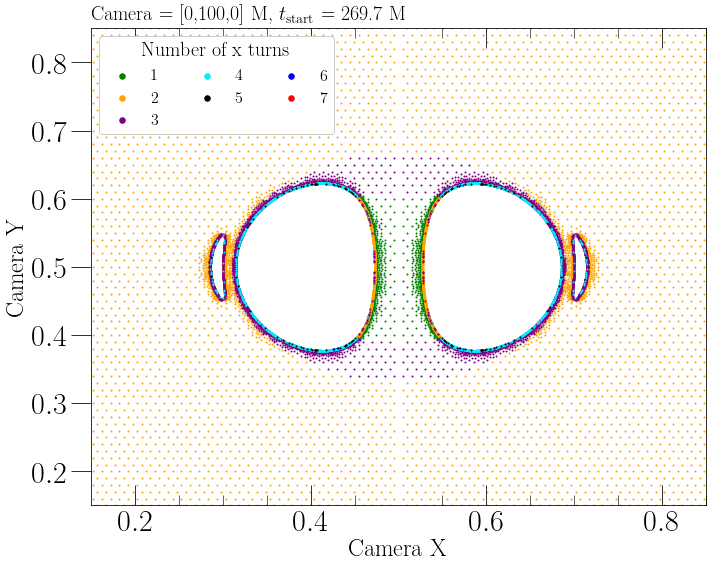

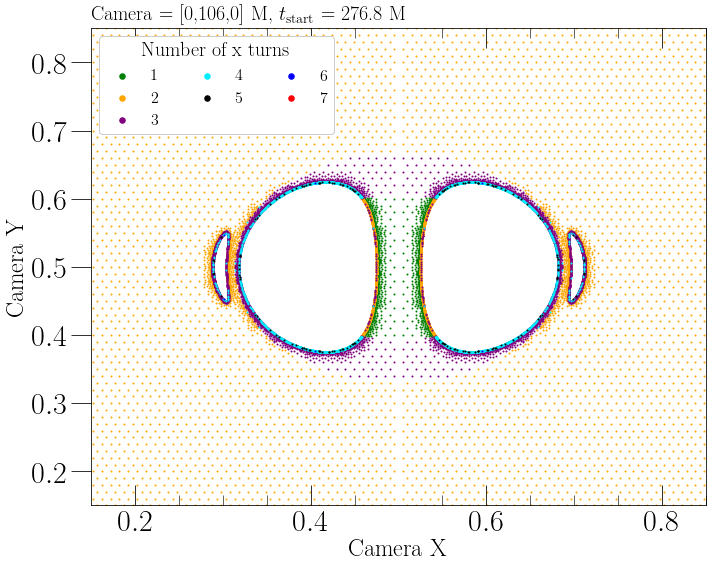

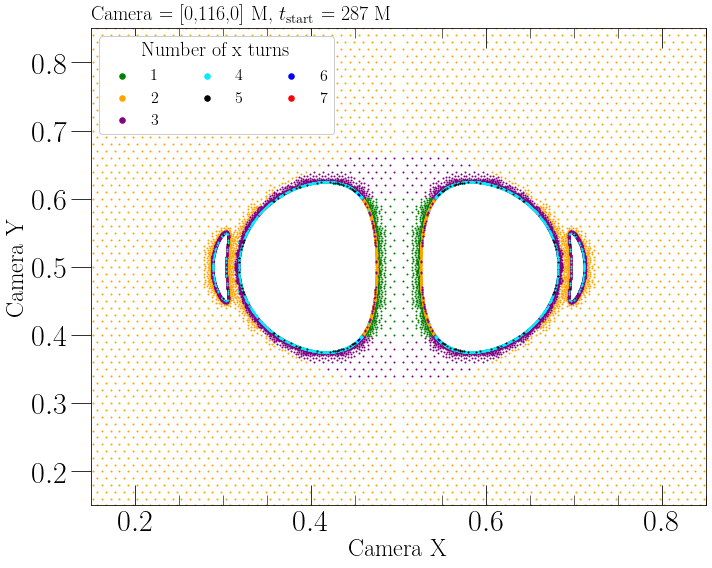

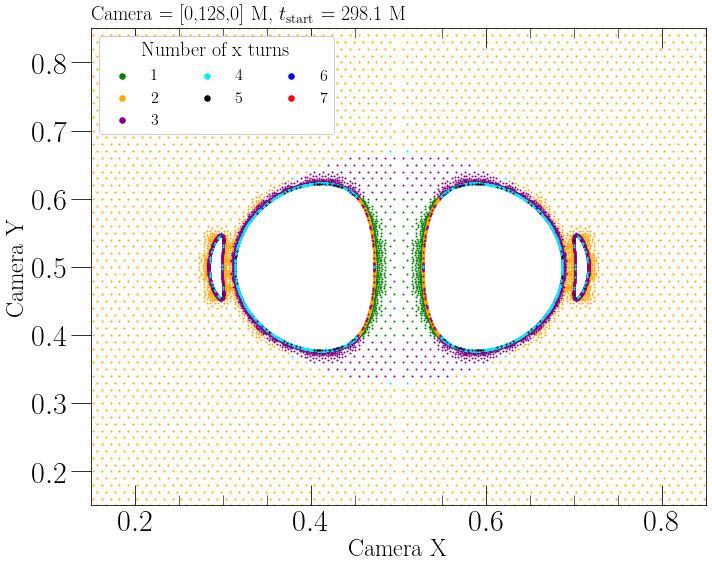

In [90]:
D = ['0_100_0_269.7', '0_106_0_276.8', '0_116_0_287', '0_128_0_298.1']
for d in D:
    p = 'Data/TraceHeadOn_' + d + '/'
    PlotRefinementMethodResult(p, xturns=True)


### Camera Interpolation

In [ ]:
## Interpolate a quantity (like the max Frenet-Serret curvature) onto the camera data
def CameraInterpolation(p):

    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    
    tags = data[:,0]
    print(len(tags))
    tags = tags.astype(int)
    x_pos = data[:,1]
    y_pos = data[:,2]
    surface = data[:,4]
    
    tags_fs, kappas = GetFrenetSerretMaxCurvatures(p)
    print(min(kappas), max(kappas))
    kappas = np.log10(kappas)

    fig = plt.figure(figsize=(10,8))
    
    z = np.array(kappas)
    rows = np.array(x_pos) 
    cols = np.array(y_pos) 
    
    ## Number of points to interpolate to
    YY = 1000
    XX = 1000
    ## number of contours
    N_cont = 1000 
    ## Bounds for the colobar
    cmap = 'jet'
    vmin = 3.0
    vmax = 3.6
    lim = 0.2
    ## Bounds for the figure

    
    xi = np.linspace(0.5 - lim, 0.5 + lim, XX)
    yi = np.linspace(0.5 - lim, 0.5 + lim, YY)

    GD = scipy.interpolate.griddata((rows, cols), z.ravel(),
                          (xi[None,:], yi[:,None]), method='cubic')

    CS = plt.contourf(xi,yi,GD,N_cont,cmap = cmap, vmin=vmin, vmax=vmax)

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(GD)
    m.set_clim(vmin, vmax)
    cbar = plt.colorbar(m, boundaries=np.linspace(vmin, vmax, 6), fraction=0.03, pad=0.01,  orientation="vertical")
    cbar.set_label(r'Max $\log_{10} \kappa$', rotation=-90, labelpad=20)
    
    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.show()